# Prévision des quotas totaux de production laitière au Québec

In [1]:
from pandas import read_csv, to_datetime, concat,\
                    DataFrame, date_range, DatetimeIndex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=13, titlesize=14)
plt.rc('legend', fontsize=12)
import statsmodels.tools.eval_measures as fa
import statsmodels.tsa.holtwinters as ets
import statsmodels.tsa.statespace.sarimax as sarima

## Read Data

In [6]:
ts = read_csv('quotatotal.csv', usecols=['Année','QC'],
              parse_dates=['Année'], infer_datetime_format=True, index_col='Année')

In [7]:
ts

,QC
Année,
2008-01-01,113.88
2009-01-01,113.18
2010-01-01,114.20
2011-01-01,116.77
2012-01-01,115.93
2013-01-01,116.19
2014-01-01,124.08
2015-01-01,126.54
2016-01-01,128.86


## Training and test sets

In [8]:
# Training set
ts_train = ts[:'2015-01-01']
print('Training Range Years: ', len(ts_train))

# Test set
ts_test = ts['2016-01-01':]
print('Testing Range Years: ', len(ts_test))

Training Range Years:  8
Testing Range Years:  2


In [9]:
ts_train.head()

,QC
Année,
2008-01-01,113.88
2009-01-01,113.18
2010-01-01,114.20
2011-01-01,116.77
2012-01-01,115.93


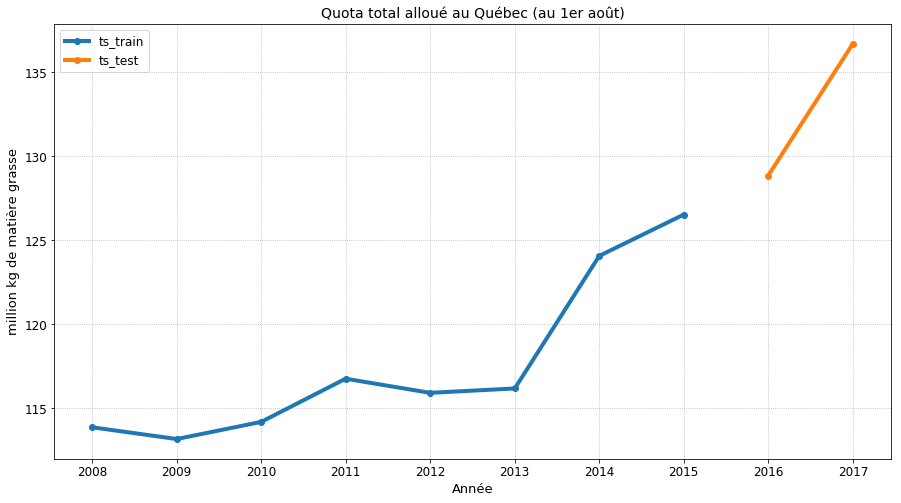

In [10]:
# Training and Test Ranges Chart
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(ts_train, label='ts_train', linewidth = 4, marker = 'o')
ax.plot(ts_test, label='ts_test', linewidth = 4, marker = 'o')
plt.legend()
plt.title('Quota total alloué au Québec (au 1er août)')
plt.ylabel('million kg de matière grasse')
plt.xlabel('Année')
ax.grid(linestyle = 'dotted')
plt.show()

Source: [Centre Canadien d'Information Laitière (CCIL)](http://www.dairyinfo.gc.ca/index_f.php?s1=dff-fcil&s2=quota&s3=if-tc)

## Simple Forecasting Methods 

In [11]:
# Average method
meanf1 = concat([ts_train.mean()]*len(ts_test))
meanf1 = DataFrame(meanf1).set_index(ts_test.index)

$$\hat{y}_{T+h|T}=\frac{1}{T}\sum_{t=1}^{T} {y_t}$$

In [12]:
# Naïve method (random walk forecasts)
rwf1 = concat([ts_train.tail(1)]*len(ts_test))
rwf1 = DataFrame(rwf1).set_index(ts_test.index)

$$\hat{y}_{T+h|T}=y_T$$

In [13]:
# Drift method (random walk with drift)
rwdf1 = concat([ts_train.tail(1)]*len(ts_test))
rwdf1 = DataFrame(rwdf1).set_index(ts_test.index)

# Drift Calculation
dts = ts-ts.shift(1)
dmeanf1 = concat([dts[:'2015-01-01'].mean()]*len(ts_test))
dmeanf1 = DataFrame(dmeanf1).set_index(ts_test.index)
driftf1 = dmeanf1.cumsum()

# Random Walk with Drift Calculation
rwdf1['Drift'] = driftf1
rwdf1 = rwdf1.sum(axis=1)
rwdf1 = DataFrame(rwdf1).set_index(ts_test.index)

$$\hat{y}_{T+h|T}=y_T+\frac{h}{T-1}\sum_{t=2}^{T} (y_t-y_{t-1})\\
=y_T+h\Big(\frac{y_T-y_1}{T-1}\Big)$$

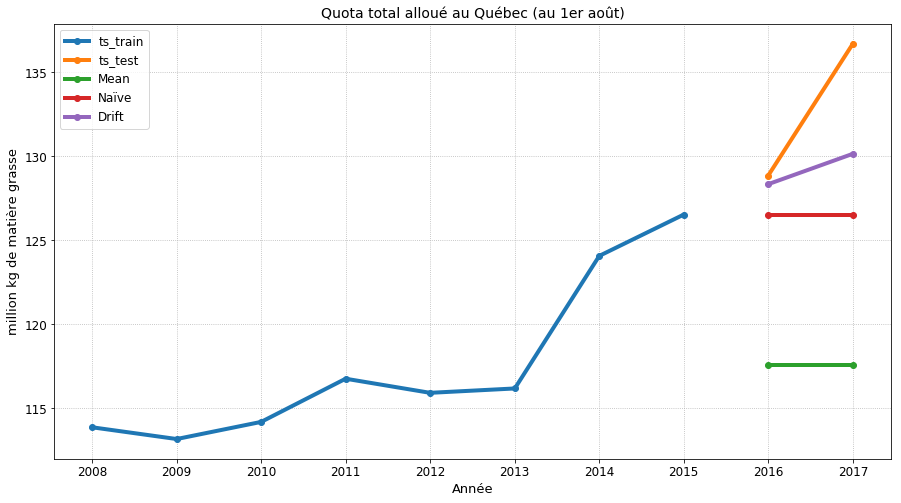

In [14]:
fig2, ax = plt.subplots(figsize=(15,8))
ax.plot(ts_train, label='ts_train', linewidth = 4, marker = 'o')
ax.plot(ts_test, label='ts_test', linewidth = 4, marker = 'o')
ax.plot(meanf1, label='Mean', linewidth = 4, marker = 'o')
ax.plot(rwf1, label='Naïve', linewidth = 4, marker = 'o')
ax.plot(rwdf1, label='Drift', linewidth = 4, marker = 'o')
plt.legend()
plt.title('Quota total alloué au Québec (au 1er août)')
plt.ylabel('million kg de matière grasse')
plt.xlabel('Année')
ax.grid(linestyle = 'dotted')
plt.show()

## Method selection

In [15]:
meanmae1 = fa.meanabs(meanf1, ts_test)
meanrmse1 = fa.rmse(meanf1, ts_test)
rwmae1 = fa.meanabs(rwf1, ts_test)
rwrmse1 = fa.rmse(rwf1, ts_test)
rwdmae1 = fa.meanabs(rwdf1, ts_test)
rwdrmse1 = fa.rmse(rwdf1, ts_test)

fadata1 = [{'0': '', '1': 'MAE', '2': 'RMSE'},
        {'0': 'Arithmetic Mean Method', '1': np.round(meanmae1, 2), '2': np.round(meanrmse1, 2)},
        {'0': 'Random Walk Method', '1': np.round(rwmae1, 2), '2': np.round(rwrmse1, 2)},
        {'0': 'Random Walk with Drift Method', '1': np.round(rwdmae1, 2), '2': np.round(rwdrmse1, 2)}]
fatable1 = DataFrame(fadata1)
print('')
print('== Multi-Steps Forecasting Accuracy ==')
print('')
print(fatable1)
print('')


== Multi-Steps Forecasting Accuracy ==

                               0        1        2
0                                     MAE     RMSE
1         Arithmetic Mean Method  [15.19]  [15.69]
2             Random Walk Method   [6.25]   [7.38]
3  Random Walk with Drift Method   [3.53]   [4.65]



## Prévision 2018 (benchmark)

In [16]:
# Training set
ts_train = ts[:'2017-01-01']
print('Training Range Years: ', len(ts_train))

# Test set
ts_test = DataFrame({'QC':[0]},
                    index=date_range('1/1/2018', periods=1))
print('Testing Range Years: ', len(ts_test))

Training Range Years:  10
Testing Range Years:  1


In [17]:
# Drift method (random walk with drift)
rwdf2018 = concat([ts_train.tail(1)]*len(ts_test))
rwdf2018 = DataFrame(rwdf2018).set_index(ts_test.index)

# Drift Calculation
dts = ts-ts.shift(1)
dmeanf2018 = concat([dts[:'2017-01-01'].mean()]*len(ts_test))
dmeanf2018 = DataFrame(dmeanf2018).set_index(ts_test.index)
driftf2018 = dmeanf2018.cumsum()

# Random Walk with Drift Calculation
rwdf2018['Drift'] = driftf2018
rwdf2018 = rwdf2018.sum(axis=1)
rwdf2018 = DataFrame(rwdf2018).set_index(ts_test.index)

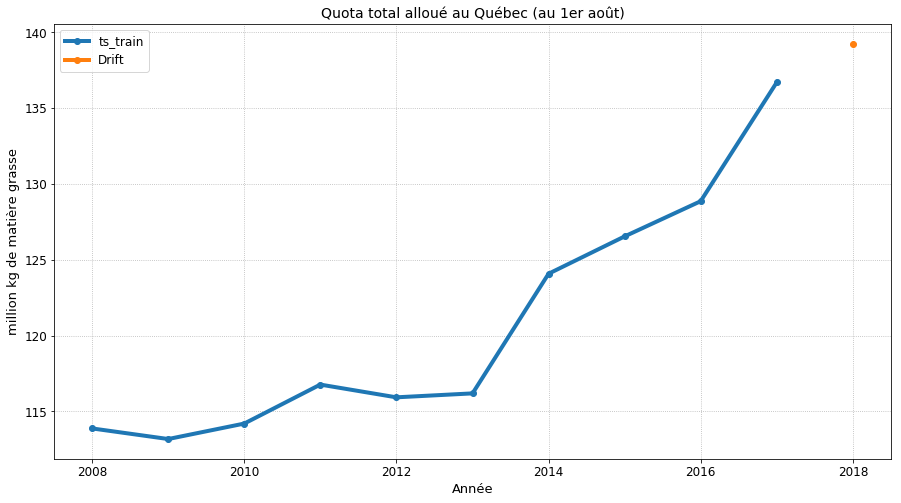

In [18]:
fig3, ax = plt.subplots(figsize=(15,8))
ax.plot(ts_train, label='ts_train', linewidth = 4, marker = 'o')
ax.plot(rwdf2018, label='Drift', linewidth = 4, marker = 'o')
plt.legend()
plt.title('Quota total alloué au Québec (au 1er août)')
plt.ylabel('million kg de matière grasse')
plt.xlabel('Année')
ax.grid(linestyle = 'dotted')
plt.show()

In [19]:
print('Prévision du quota total alloué au QC (août 2018): %.2f' % rwdf2018[0])

Prévision du quota total alloué au QC (août 2018): 139.25


## Training and test sets

In [20]:
# Training set
ts_train = ts[:'2015-01-01']
print('Training Range Years: ', len(ts_train))

# Test set
ts_test = ts['2016-01-01':]
print('Testing Range Years: ', len(ts_test))

Training Range Years:  8
Testing Range Years:  2


In [21]:
ts_train.index = DatetimeIndex(ts_train.index.values,
                               freq=ts_train.index.inferred_freq)

In [22]:
ts_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8 entries, 2008-01-01 to 2015-01-01
Freq: AS-JAN
Data columns (total 1 columns):
QC    8 non-null float64
dtypes: float64(1)
memory usage: 128.0 bytes


## Exponential Smoothing Methods

In [23]:
# Holt's Linear Trend Method - ETS(A,A,N)

holtt1 = ets.ExponentialSmoothing(ts_train, trend='additive', damped=False, seasonal=None).fit()
print('')
print('== Holt Linear Trend ETS(A,A,N) Parameters ==')
print('')
print('Smoothing Level: ', np.round(holtt1.params['smoothing_level'], 4))
print('Smoothing Slope: ', np.round(holtt1.params['smoothing_slope'], 4))
print('Initial Level: ', np.round(holtt1.params['initial_level'], 4))
print('Initial Slope: ', np.round(holtt1.params['initial_slope'], 4))
print('')
holtf1 = holtt1.forecast(steps=len(ts_test))
holtf1 = DataFrame(holtf1).set_index(ts_test.index)


== Holt Linear Trend ETS(A,A,N) Parameters ==

Smoothing Level:  0.6316
Smoothing Slope:  0.6316
Initial Level:  113.88
Initial Slope:  0.0



In [24]:
# Exponential (multiplicative) Trend Method - ETS(A,M,N)

expt1 = ets.ExponentialSmoothing(ts_train.iloc[:, 0].values, trend='multiplicative', damped=False,
                                 seasonal=None).fit()
print('')
print('== Exponential Trend ETS(A,M,N) Parameters ==')
print('')
print('Smoothing Level: ', np.round(expt1.params['smoothing_level'], 4))
print('Smoothing Slope: ', np.round(expt1.params['smoothing_slope'], 4))
print('Initial Level: ', np.round(expt1.params['initial_level'], 4))
print('Initial Slope: ', np.round(expt1.params['initial_slope'], 4))
print('')
expf1 = expt1.forecast(steps=len(ts_test))
expf1 = DataFrame(expf1).set_index(ts_test.index)


== Exponential Trend ETS(A,M,N) Parameters ==

Smoothing Level:  0.6316
Smoothing Slope:  0.6316
Initial Level:  113.88
Initial Slope:  0.9939



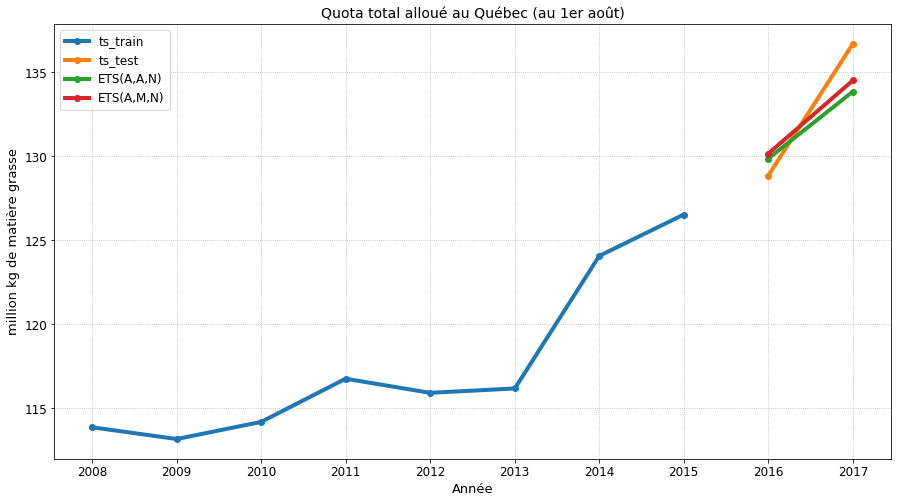

In [25]:
fig4, ax = plt.subplots(figsize=(15,8))
ax.plot(ts_train, label='ts_train', linewidth = 4, marker = 'o')
ax.plot(ts_test, label='ts_test', linewidth = 4, marker = 'o')
ax.plot(holtf1, label='ETS(A,A,N)', linewidth = 4, marker = 'o')
ax.plot(expf1, label='ETS(A,M,N)', linewidth = 4, marker = 'o')
plt.legend()
plt.title('Quota total alloué au Québec (au 1er août)')
plt.ylabel('million kg de matière grasse')
plt.xlabel('Année')
ax.grid(linestyle = 'dotted')
plt.show()

## Method selection

In [26]:
# Exponential Smoothing Method Selection

holtaict1 = holtt1.aic
holtbict1 = holtt1.bic
expaict1 = expt1.aic
expbict1 = expt1.bic

msdata1 = [{'0': '', '1': 'AIC', '2': 'BIC'},
        {'0': 'Holt Linear Trend ETS(A,A,N) Method', '1': np.round(holtaict1, 4),
         '2': np.round(holtbict1, 4)},
        {'0': 'Exponential Trend ETS(A,M,N) Method', '1': np.round(expaict1, 4),
         '2': np.round(expbict1, 4)},
           ]
mstable1 = DataFrame(msdata1)
print('')
print('== Exponential Smoothing Method Selection ==')
print('')
print(mstable1)
print('')


== Exponential Smoothing Method Selection ==

                                     0        1       2
0                                           AIC     BIC
1  Holt Linear Trend ETS(A,A,N) Method  24.7552  25.073
2  Exponential Trend ETS(A,M,N) Method  24.7983  25.116



In [27]:
# Methods Forecasting Accuracy

holtmae1 = fa.meanabs(holtf1, ts_test)
holtrmse1 = fa.rmse(holtf1, ts_test)
expmae1 = fa.meanabs(expf1, ts_test)
exprmse1 = fa.rmse(expf1, ts_test)

fadata1 = [{'0': '', '1': 'MAE', '2': 'RMSE'},
        {'0': 'Random Walk with Drift Method (benchmark)', '1': np.round(rwdmae1, 4),
         '2': np.round(rwdrmse1, 4)},
        {'0': 'Holt Linear Trend ETS(A,A,N) Method', '1': np.round(holtmae1, 4),
         '2': np.round(holtrmse1, 4)},
        {'0': 'Exponential Trend ETS(A,M,N) Method', '1': np.round(expmae1, 4),
         '2': np.round(exprmse1, 4)},
           ]
fatable1 = DataFrame(fadata1)
print('')
print('== Multi-Steps Forecasting Accuracy ==')
print('')
print(fatable1)
print('')


== Multi-Steps Forecasting Accuracy ==

                                           0         1         2
0                                                  MAE      RMSE
1  Random Walk with Drift Method (benchmark)  [3.5321]  [4.6477]
2        Holt Linear Trend ETS(A,A,N) Method  [1.9293]   [2.137]
3        Exponential Trend ETS(A,M,N) Method  [1.7446]  [1.7992]



## Prévision 2018 (best)

In [28]:
# Training set
ts_train = ts[:'2017-01-01']
print('Training Range Years: ', len(ts_train))

# Test set
ts_test = DataFrame({'QC':[0]},
                    index=date_range('1/1/2018', periods=1))
print('Testing Range Years: ', len(ts_test))

Training Range Years:  10
Testing Range Years:  1


In [29]:
# Exponential Trend Method ETS(A,M,N)

expt2018 = ets.ExponentialSmoothing(ts_train.iloc[:, 0].values, trend='multiplicative', damped=False,
                                 seasonal=None).fit()
expf2018 = expt2018.forecast(steps=len(ts_test))
expf2018 = DataFrame(expf2018).set_index(ts_test.index)

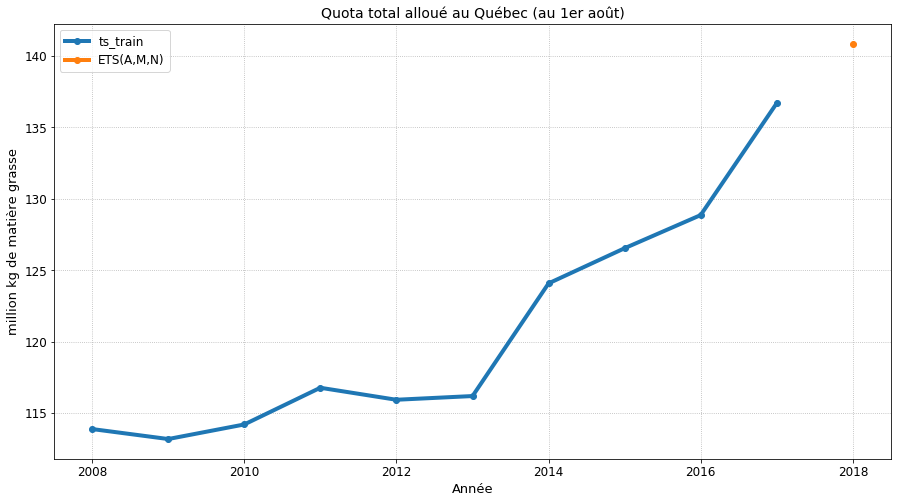

In [30]:
fig5, ax = plt.subplots(figsize=(15,8))
ax.plot(ts_train, label='ts_train', linewidth = 4, marker = 'o')
ax.plot(expf2018, label='ETS(A,M,N)', linewidth = 4, marker = 'o')
plt.legend()
plt.title('Quota total alloué au Québec (au 1er août)')
plt.ylabel('million kg de matière grasse')
plt.xlabel('Année')
ax.grid(linestyle = 'dotted')
plt.show()

In [31]:
print('Prévision du quota total alloué au QC (août 2018): %.2f' % expf2018[0])

Prévision du quota total alloué au QC (août 2018): 140.86


La valeur est très proche de la dernière valeur publiée dans le rapport annuel 2017 de la FPLQ, 140,05 kg de MG (décembre 2017).

## ARIMA Models

## Training and test sets

In [32]:
# Training set
ts_train = ts[:'2015-01-01']
print('Training Range Years: ', len(ts_train))

# Test set
ts_test = ts['2016-01-01':]
print('Testing Range Years: ', len(ts_test))

Training Range Years:  8
Testing Range Years:  2


In [33]:
ts_train.index = DatetimeIndex(ts_train.index.values,
                               freq=ts_train.index.inferred_freq)

In [34]:
# Random Walk with Drift Model ARIMA(0,1,0) With Constant

arwdt1 = sarima.SARIMAX(ts_train, order=(0, 1, 0), trend='c').fit(disp=-1)
print('')
print('== Random Walk with Drift Model ARIMA(0,1,0) With Constant Parameters ==')
print('')
print(arwdt1.params)
print('')
arwdf1 = arwdt1.forecast(steps=len(ts_test))
arwdf1 = DataFrame(arwdf1).set_index(ts_test.index)


== Random Walk with Drift Model ARIMA(0,1,0) With Constant Parameters ==

intercept    1.808571
sigma2       7.759384
dtype: float64



/Users/mldev/vini/Forecasting-master/forecasting_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [35]:
# Differentiated First Order Autoregressive ARIMA(1,1,0) With Constant

dart1 = sarima.SARIMAX(ts_train, order=(1, 1, 0), trend='c').fit(disp=-1)
print('')
print('== Differentiated First Order Autoregressive ARIMA(1,1,0) With Constant Parameters ==')
print('')
print(dart1.params)
print('')
darf1 = dart1.forecast(steps=len(ts_test))
darf1 = DataFrame(darf1).set_index(ts_test.index)


== Differentiated First Order Autoregressive ARIMA(1,1,0) With Constant Parameters ==

intercept    1.884137
ar.L1       -0.036373
sigma2       7.747566
dtype: float64



In [36]:
# Brown Simple Exponential Smoothing ARIMA(0,1,1) Without Constant

abrownt1 = sarima.SARIMAX(ts_train, order=(0, 1, 1), trend=None).fit(disp=-1)
print('')
print('== Brown Simple Exponential Smoothing ARIMA(0,1,1) Without Constant Parameters ==')
print('')
print(abrownt1.params)
print('')
abrownf1 = abrownt1.forecast(steps=len(ts_test))
abrownf1 = DataFrame(abrownf1).set_index(ts_test.index)


== Brown Simple Exponential Smoothing ARIMA(0,1,1) Without Constant Parameters ==

ma.L1     0.578968
sigma2    9.143194
dtype: float64



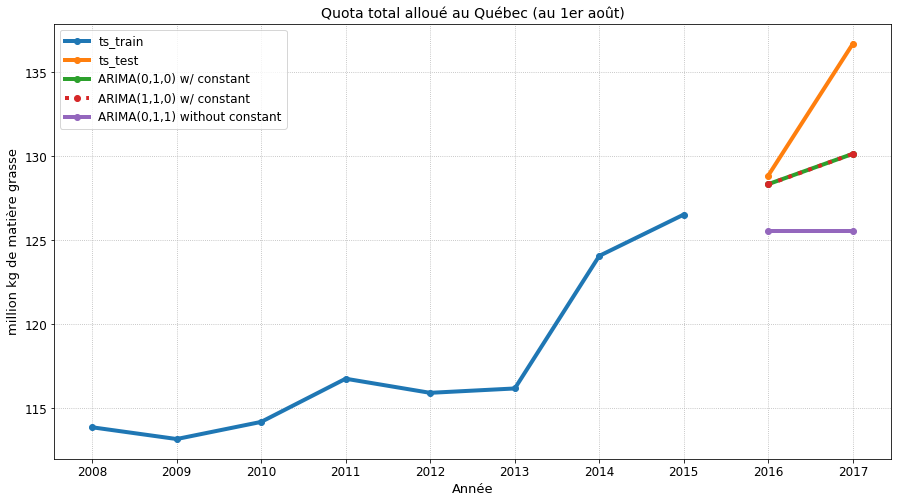

In [37]:
fig6, ax = plt.subplots(figsize=(15,8))
ax.plot(ts_train, label='ts_train', linewidth = 4, marker = 'o')
ax.plot(ts_test, label='ts_test', linewidth = 4, marker = 'o')
ax.plot(arwdf1, label='ARIMA(0,1,0) w/ constant', linewidth = 4, marker = 'o')
ax.plot(darf1, label='ARIMA(1,1,0) w/ constant', linewidth = 4, marker = 'o',
       linestyle = 'dotted')
ax.plot(abrownf1, label='ARIMA(0,1,1) without constant', linewidth = 4, marker = 'o')
plt.legend()
plt.title('Quota total alloué au Québec (au 1er août)')
plt.ylabel('million kg de matière grasse')
plt.xlabel('Année')
ax.grid(linestyle = 'dotted')
plt.show()

## Model selection

In [38]:
# ARIMA Model Selection

arwdaict1 = arwdt1.aic
arwdbict1 = arwdt1.bic
daraict1 = dart1.aic
darbict1 = dart1.bic
abrownaict1 = abrownt1.aic
abrownbict1 = abrownt1.bic

msdata = [{'0': '', '1': 'AIC', '2': 'BIC'},
        {'0': 'Random Walk with Drift ARIMA(0,1,0) Model 1', '1': np.round(arwdaict1, 4),
         '2': np.round(arwdbict1, 4)},
        {'0': 'Differentiated First Order ARIMA(1,1,0) Model 1', '1': np.round(daraict1, 4),
         '2': np.round(darbict1, 4)},
        {'0': 'Brown Simple Exponential Smoothing ARIMA(0,1,1) Model 1', '1': np.round(abrownaict1, 4),
         '2': np.round(abrownbict1, 4)},
          ]
mstable = DataFrame(msdata)
print('')
print('== ARIMA Model Selection ==')
print('')
print(mstable)
print('')


== ARIMA Model Selection ==

                                                   0        1        2
0                                                         AIC      BIC
1        Random Walk with Drift ARIMA(0,1,0) Model 1  38.2075  38.0993
2    Differentiated First Order ARIMA(1,1,0) Model 1  40.1981  40.0358
3  Brown Simple Exponential Smoothing ARIMA(0,1,1...  39.7644  39.6562



In [39]:
# Models Forecasting Accuracy

expmae1 = fa.meanabs(expf1, ts_test)
exprmse1 = fa.rmse(expf1, ts_test)
arwdmae1 = fa.meanabs(arwdf1, ts_test)
arwdrmse1 = fa.rmse(arwdf1, ts_test)
darmae1 = fa.meanabs(darf1, ts_test)
darrmse1 = fa.rmse(darf1, ts_test)
abrownmae1 = fa.meanabs(abrownf1, ts_test)
abrownrmse1 = fa.rmse(abrownf1, ts_test)

fadata1 = [{'0': '', '1': 'MAE', '2': 'RMSE'},
        {'0': 'Exponential Trend ETS(A,M,N) Method (benchmark)', '1': np.round(expmae1, 4),
         '2': np.round(exprmse1, 4)},
        {'0': 'Random Walk with Drift ARIMA(0,1,0) Model', '1': np.round(arwdmae1, 4),
         '2': np.round(arwdrmse1, 4)},
        {'0': 'Differentiated First Order ARIMA(1,1,0) Model', '1': np.round(darmae1, 4),
         '2': np.round(darrmse1, 4)},
        {'0': 'Brown Simple Exponential Smoothing ARIMA(0,1,1) Model', '1': np.round(abrownmae1, 4),
         '2': np.round(abrownrmse1, 4)},
           ]
fatable1 = DataFrame(fadata1)
print('')
print('== Multi-Steps Forecasting Accuracy ==')
print('')
print(fatable1)
print('')


== Multi-Steps Forecasting Accuracy ==

                                                   0         1         2
0                                                          MAE      RMSE
1    Exponential Trend ETS(A,M,N) Method (benchmark)  [1.7446]  [1.7992]
2          Random Walk with Drift ARIMA(0,1,0) Model  [3.5321]  [4.6477]
3      Differentiated First Order ARIMA(1,1,0) Model  [3.5409]   [4.651]
4  Brown Simple Exponential Smoothing ARIMA(0,1,1...  [7.2025]  [8.2025]



## Advanced forecasting models
- Vector autoregression models (VAR and VARX)
- Econometric structural models (SM)
- Neural network autoregression (NNAR)

## Econometric Model for Short-Term Forecasting (structural model)

# Un modèle économétrique pour la gestion en continu du quota

La CCL/CCGAL a mentionnée dans son dernier [rapport annuel 2016-2017](http://www.cdc-ccl.gc.ca/CDC/index-fra.php?link=125) son intention de modifier sa méthodologie d'ajuste de quota pour mieux répondre à la variation de la demande. Un modèle économétrique d'estimation de quota dynamique me semble plus approprié. C'est le cas de la régression avec les données de séries temporelles de fréquence mensuelle.

Après avoir compris le système complexe de gestion de l'offre au Canada et au Québec et avoir trouvé les sources de données, cela me semble être une tâche "plus simple" !! Les jeux de données que je trouve les plus pertinents sont disponibles ici:

1. [Ventes commerciales de lait et de crème: 32-10-0114-01 (anciennement CANSIM  003-0012)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=3210011401)
1. [Production et utilisation de lait: 32-10-0113-01 (anciennement CANSIM  003-0011)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=3210011301)
1. [Fabrication de sous-produits concentrés de lait: 32-10-0247-01 (anciennement CANSIM  003-0029)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=3210024701)
1. [Recettes monétaires des ventes de lait et de crème hors ferme: 32-10-0110-01 (anciennement CANSIM  003-0008)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=3210011001)
1. [Stocks de certains produits laitiers: 32-10-0001-01 (anciennement CANSIM  003-0033)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=3210000101)
1. [Prix de détail moyens mensuels pour les aliments et autres produits sélectionnés: 18-10-0002-01 (anciennement CANSIM  326-0012)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=1810000201)
1. [Production de la matière grasse (x 1 000): 32-10-0132-01 (anciennement CANSIM  003-0034)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=3210013201)
1. [Indice des prix à la consommation, données mensuelles non désaisonnalisées: 18-10-0004-03 (anciennement CANSIM  326-0020)](https://www150.statcan.gc.ca/t1/tbl1/fr/tv.action?pid=1810000403)
1. [Importations et exportations de produits laitiers](http://www.dairyinfo.gc.ca/index_f.php?s1=dff-fcil#trade)

Références:

1. [Curtin, L., Rakowski, P., Lee, P. Y., Jeffrey, S., ***Profil de l'industrie laitière canadienne*** mars 1998, Enquêtes sur questions économiques et tarifaires, Rapports du personnel, GC-97-001](http://www.citt.gc.ca/fr/refer/staffrep/archive_gc9701a_f)
1. [Ewing, R. (Chercheuse principale), ***Analyse économique utilisant le modèle FARM*** mars 1998, Enquêtes sur questions économiques et tarifaires, Rapports du personnel, GC-97-001](http://www.citt.gc.ca/fr/refer/staffrep/archive_gc9701d_f)
1. [Hyndman, R. J., Athanasopoulos, G., ***Forecasting: Principles and Practice*** avril 2018](https://otexts.org/fpp2/)
1. [Romain, R., ***Évaluation de l'analyse en simulation utilizant le modèle FARM réalisée para Agriculture et Agroalimentaire Canada*** avril 1998, Enquêtes sur questions économiques et tarifaires, Rapports du personnel, GC-97-001](http://www.citt.gc.ca/fr/refer/staffrep/archive_gc9701h_f)
1. [Tribunal Canadien du Commerce Extérieur, ***ENQUÊTE SUR L'IMPORTATION DE MÉLANGES DE PRODUITS LAITIERS ÉCHAPPANT AUX LIMITES DES CONTINGENTS DU CANADA***](http://www.citt.gc.ca/fr/saisines?field_case_year_value%5Bvalue%5D%5Byear%5D=1997)

Autres références:

1. [Borde, Valérie, ***Les défis du lait québécois*** mai 2016, *L'actualité*](https://lactualite.com/societe/2016/05/10/les-defis-du-lait-quebecois/)
1. [The Boston Consulting Group, ***Analyse des impacts potentiels de la fin de la gestion de l'offre dans l'industrie laitière au Canada*** décembre 2015](https://www.agrireseau.net/economie-et-gestion/documents/91368)
1. [Boyer, Marcel; Charlebois, Sylvain, ***La gestion de l’offre des produits agricoles : un système coûteux pour les consommateurs*** août 2007, *IEDM*](https://www.iedm.org/fr/588-la-gestion-de-loffre-des-produits-agricoles-un-systeme-couteux-pour-les-consommateurs)
1. [Commission Canadienne du lait, ***Rapport annuel de la CCL 2016-2017*** août 2017](http://www.cdc-ccl.gc.ca/CDC/index-fra.php?link=125)
1. [Duhamel, Pierre, ***Lait: une histoire de vaches… et de sous*** juillet 2013, *L'actualité*](https://lactualite.com/lactualite-affaires/2013/07/23/le-lait-une-histoire-de-vaches-et-de-sous/)
1. [Dumais, Mario; Chassin, Youri, ***Les politiques néfastes de gestion de l’offre du Canada*** juin 2015, *IEDM*](http://www.iedm.org/fr/53769-le-point-les-politiques-nefastes-de-gestion-de-l-offre-du-Canada)
1. [Export Action Global, ***Les Systèmes Laitiers dans le Monde: Les consommateurs et les producteurs canadiens s’en tirent-ils mieux avec le modèle canadien?*** avril 2018](https://www.exportactionglobal.com/dairyreport/)
1. [Fillion, Gérald, ***Gestion de l'offre : pourquoi le lait coûte-t-il plus cher au Québec?*** mai 2017, ici.radio-canada.ca](https://ici.radio-canada.ca/nouvelle/1036806/gestion-de-offre-pourquoi-lait-coute-plus-cher-au-quebec)
1. [Gouin, Daniel-Mercier; Doyon, Maurice, ***La gestion de l'offre attaquée à coups de sophismes*** mai 2017, *La Presse*](http://plus.lapresse.ca/screens/c41361e6-1861-4267-b962-f87e74a758d0__7C___0.html)
1. [Grant, Michael; Barichello, Richard; Liew, Mark; Gill, Vijay, ***Réformer la gestion de l’offre laitière : Plaidoyer pour la croissance*** 2014, Ottawa, Le Conference Board du Canada](https://www.conferenceboard.ca/e-library/abstract.aspx?did=6084)
1. [Heminthavong, Khamla, ***Le mécanisme de la gestion de l’offre au Canada*** décembre 2015, *Division de l’économie, des ressources et des affaires internationales*, 2015-138-F](https://bdp.parl.ca/Content/LOP/ResearchPublications/2015-138-f.html?cat=agriculture)
1. [L'Institut économique de Montréal, ***Production laitière : les coûts de la gestion de l’offre au Canada*** février 2005, *Les Notes Économiques*](http://www.caaaq.gouv.qc.ca/userfiles/File/MEIDairy%20fev05_FRENCH.pdf)
1. [L'Union Paysanne, ***Vers une gestion de l’offre 2.0 au Canada*** novembre 2014](https://unionpaysanne.com/publications/)
1. [Les Producteurs de lait du Québec, ***Bilan annuel du marché laitier des Producteurs de lait du Québec - Croissance et investissements dans le secteur laitier, atténués par l'entrée en vigueur des accords commerciaux*** avril 2018, Cision](https://www.newswire.ca/fr/news-releases/bilan-annuel-du-marche-laitier-des-producteurs-de-lait-du-quebec---croissance-et-investissements-dans-le-secteur-laitier-attenues-par-lentree-en-vigueur-des-accords-commerciaux-679406953.html)
1. [Les Protucteurs Laitiers du Canada, ***Rapport Annuel 2017***](http://lait.org/notre-organisation/rapport-annuel/)
1. [Les Protucteurs Laitiers du Canada, ***Pourquoi la gestion de l’offre fonctionne-t-elle pour les Canadiens?*** 2017](https://www.producteurslaitiers.ca/que-faisons-nous/a-propos-de-la-gestion-de-l-offre/pourquoi-la-gestion-de-l-offre-fonctionne-t-elle-pour-les-canadiens)
1. [Les Protucteurs Laitiers du Canada, ***Les producteurs remettent les pendules à l'heure au sujet de la gestion de l'offre deuxième partie*** 2015, communiqué](https://www.producteurslaitiers.ca/salle-de-presse/nouvelles/politique/les-producteurs-remettent-les-pendules-a-l-heure-au-sujet-de-la-gestion-de-l-offre-deuxieme-partie)
1. [Lippert, Owen, ***Milk: A Perfect Mess Revisited*** 2018, iPOLITICS](https://ipolitics.ca/article/milk-a-perfect-mess-revisited/)
1. [Lippert, Owen, ***The Perfect Food in a Perfect Mess: The Cost of Milk in Canada*** 2001, *Public Policy Sources*, 52, The Fraser Institute](https://www.fraserinstitute.org/sites/default/files/PerfectFoodinaPerfectMess.pdf)
1. [Régie des marchés agricoles et alimentaires du Québec, ***Rapport annuel de gestion (2016-2017)*** septembre 2017](http://www.rmaaq.gouv.qc.ca//index.php?id=12)
1. [St. Pierre, Michelle, ***Changements dans les préférences des Canadiens relativement au lait et aux produits laitiers*** avril 2017, *Regards sur l'industrie agro-alimentaire et la communauté agricole*, 21-004-X](https://www150.statcan.gc.ca/n1/pub/21-004-x/2017001/article/14786-fra.htm)